In [1]:
# !pip install geomloss
import os
import time
import torch
import cv2
import numpy as np
# from geomloss import SamplesLoss
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.transforms import transforms
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import cdist
from scipy.io import loadmat

In [2]:
torch.manual_seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Model

In [4]:
convNext = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
convNext = convNext.to(device)


class ConvNext_Tiny_Backbone(nn.Module):

    def __init__(self):
        super().__init__()
    
    
    def forward(self, x):   
        x = convNext.features[0](x)
        x = convNext.features[1](x) # 96
        x = convNext.features[2](x)
        x = convNext.features[3](x) # 192
        F1 = x

        x = convNext.features[4](x)
        x = convNext.features[5](x) # 384
        F2 = x

        x = convNext.features[6](x)
        x = convNext.features[7](x) # 768
        F3 = x

        return F1, F2, F3

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:01<00:00, 60.0MB/s] 


In [5]:
class MultiScaleFusion(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.transpose2 = nn.ConvTranspose2d(384, 384, kernel_size=2, stride=2)
        self.transpose3 = nn.ConvTranspose2d(768, 768, kernel_size=4, stride=4)

    
    def forward(self, s1, s2, s3):
        h, w = s1.shape[2], s1.shape[3]
        s2 = self.transpose2(s2)
        s3 = self.transpose3(s3)

        S = torch.cat([s1, s2, s3], dim=1)

        return S

In [6]:
class FFNet(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.backbone = ConvNext_Tiny_Backbone()
        self.fusion = MultiScaleFusion()

        self.conv = nn.Conv2d(1344, 1, kernel_size=1)
    

    def forward(self, x):

        f1, f2, f3 = self.backbone(x)

        S = self.fusion(f1, f2, f3)

        density_map = self.conv(S)

        return density_map

In [ ]:
model = FFNet()
model = model.to(device)

# Dataset Pipeline

In [7]:
k_nearest = 3
beta = 0.3

def generate_density_map(img, points):

    img_width, img_height = img.size
    d_map_height = img_height // 8
    d_map_width = img_width // 8
    density_map = np.zeros((d_map_height, d_map_width), dtype=np.float32)
    
    if len(points) == 0:
        return density_map

    scaled_points = points / 8
    
    sigmas = []
    if len(scaled_points) > 1:
        distances = cdist(scaled_points, scaled_points)
        
        for i in range(len(scaled_points)):
            sorted_distances = np.sort(distances[i][distances[i] > 1e-6])
            
            if len(sorted_distances) >= k_nearest:
                d_k = sorted_distances[k_nearest - 1]
                sigma_i = beta * d_k
            else:
                sigma_i = beta * np.mean(sorted_distances) if len(sorted_distances) > 0 else 1.0
            sigmas.append(sigma_i)
    else:
        sigmas.append(4.0)
    
    sigmas = np.array(sigmas)
    
    for i, (x, y) in enumerate(scaled_points):
        if int(y) < d_map_height and int(x) < d_map_width:
            point_map = np.zeros_like(density_map)
            point_map[int(y), int(x)] = 1.0
            
            blurred_point_map = gaussian_filter(point_map, sigma=sigmas[i], mode='constant')

            density_map += blurred_point_map
    
    return density_map

In [8]:
class CustomDataset(Dataset):

    def __init__(self, img_folder_path, point_folder_path):
        self.img_folder_path = img_folder_path
        self.point_folder_path = point_folder_path
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])


    def __len__(self):
        return(len(os.listdir(self.img_folder_path)))


    def __getitem__(self, index):
        img_path = os.path.join(self.img_folder_path, f"IMG_{index+1}.jpg")
        point_path = os.path.join(self.point_folder_path, f"GT_IMG_{index+1}.mat")

        img = Image.open(img_path).convert("RGB")

        data = loadmat(point_path)
        point = data["image_info"][0][0][0][0][0]

        density_map = generate_density_map(img, points=point.astype(int))
        density_map = torch.from_numpy(density_map).float().unsqueeze(0)

        img = self.transform(img)

        return img, density_map

In [9]:
train_dataset = CustomDataset("/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/images", "/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/ground_truth")
test_dataset = CustomDataset("/kaggle/input/crowd-dataset/crowd_wala_dataset/test_data/images", "/kaggle/input/crowd-dataset/crowd_wala_dataset/test_data/ground_truth")

In [10]:
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

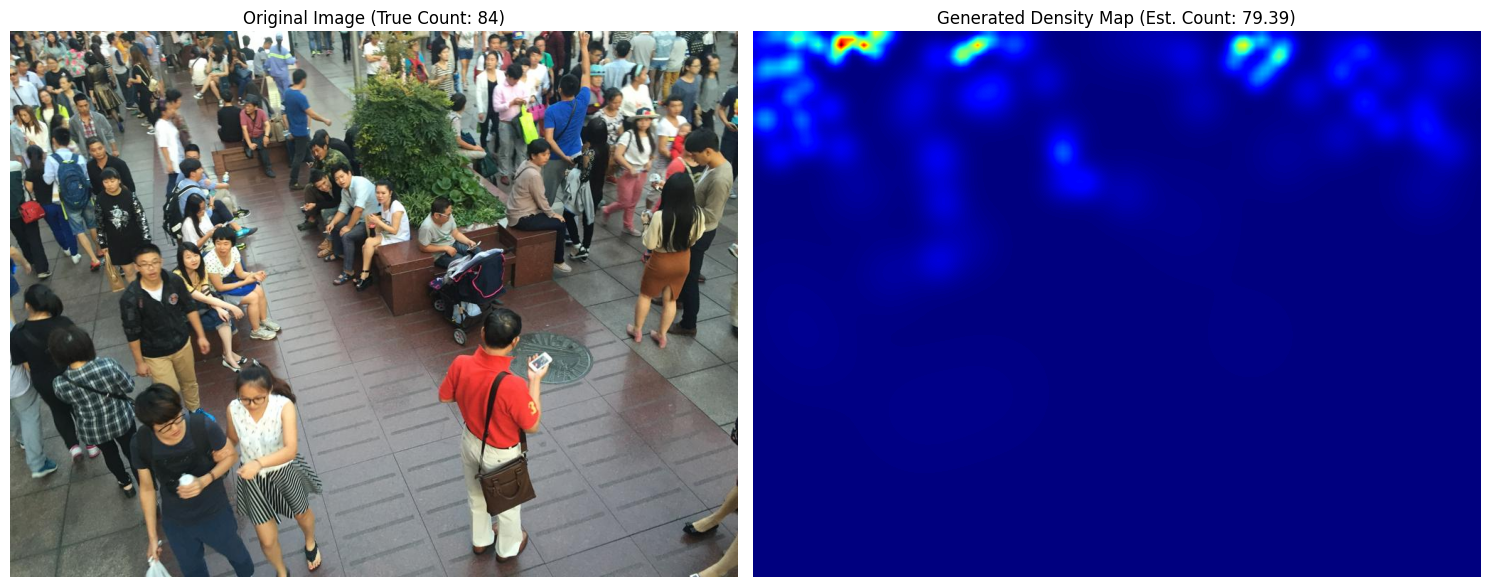

In [12]:
data = loadmat('/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/ground_truth/GT_IMG_40.mat')
point = data["image_info"][0][0][0][0][0]


img = Image.open("/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/images/IMG_40.jpg").convert("RGB")

density_map = generate_density_map(img, points=point.astype(int))
density_map_tensor = torch.from_numpy(density_map).float().unsqueeze(0).unsqueeze(0)

upsampled_density_map = torch.nn.functional.interpolate(
    density_map_tensor,
    size=(img.size[1], img.size[0]),
    mode='bilinear',
    align_corners=False).squeeze().cpu().numpy()


true_count = len(point)
estimated_count = np.sum(density_map)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f'Original Image (True Count: {true_count})')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(upsampled_density_map, cmap='jet')
plt.title(f'Generated Density Map (Est. Count: {estimated_count:.2f})')
plt.axis('off')

plt.tight_layout()
plt.show()

# Loss Fxn

In [ ]:
class LossFxn(nn.Module):

    def __init__(self, lambda1 = 0.1, lambda2 = 0.01):

        super(LossFxn, self).__init__()

        self.lambda1 = lambda1
        self.lambda2 = lambda2

        ot_params = {'loss': 'sinkhorn', 'p': 2, 'blur': 10, 'debias': True}

        self.ot_loss_fxn = SamplesLoss(**ot_params)
        self.variational_loss = nn.L1Loss()


    def forward(self, y_true, y_pred):

        B, _, H, W = y_pred.shape

        pred_flat = y_pred.view(B, -1) + 1e-8
        true_flat = y_true.view(B, -1) + 1e-8

        pred_dist_norm = pred_flat / pred_flat.sum(dim=1, keepdim=True)
        true_dist_norm = true_flat / true_flat.sum(dim=1, keepdim=True)

        coords_x = torch.arange(W, device=y_pred.device, dtype=y_pred.dtype)
        coords_y = torch.arange(H, device=y_pred.device, dtype=y_pred.dtype)
        
        grid_x, grid_y = torch.meshgrid(coords_x, coords_y, indexing='ij')
        pixel_coords = torch.stack((grid_x.flatten(), grid_y.flatten()), dim=-1)
        pixel_coords_batch = pixel_coords.unsqueeze(0).repeat(B, 1, 1)
        
        ot_loss = self.ot_loss_fxn(pred_dist_norm, pixel_coords_batch, true_dist_norm, pixel_coords_batch)

        count_loss = self.variational_loss(y_true.sum(dim=[1, 2, 3]), y_pred.sum(dim=[1, 2, 3])) / B
        variational_loss = self.variational_loss(y_pred, y_true) / B

        total_loss = count_loss + (self.lambda1 * ot_loss) + (self.lambda2 * variational_loss)

        return total_loss

In [14]:
learning_rate = 0.0001
epochs = 5

loss_fxn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop

In [ ]:
start = time.time()
losses = []


for i in range(epochs):

    total_epoch_loss = 0
    count = 0

    for batch_image, batch_density_map in train_loader:

        batch_image, batch_density_map = batch_image.to(device), batch_density_map.to(device)

        output = model(batch_image)

        loss = loss_fxn(output, batch_density_map)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        print(f"Batch No.: {count}, Time Elapsed: {(time.time() - start):.1f}, Loss: {loss.item():.5f}")
    
        total_epoch_loss += loss.item()
        losses.append(loss.item())

    avg_epoch_loss = total_epoch_loss / len(train_loader)
    print(f"Epoch: {i+1}, Loss: {avg_epoch_loss}")        

In [ ]:
plt.plot(range(1, 2001), losses)
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model_weights_FFNet.pth')

In [13]:
model = FFNet()
model = model.to(device)
model.load_state_dict(torch.load('/kaggle/input/ffnet-fusiontransition/pytorch/default/1/model_weights_FFNet-FusionTransition.pth'))

<All keys matched successfully>

# Evaluation

In [15]:
model.eval()

FFNet(
  (backbone): ConvNext_Tiny_Backbone()
  (fusion): MultiScaleFusion(
    (transpose2): ConvTranspose2d(384, 384, kernel_size=(2, 2), stride=(2, 2))
    (transpose3): ConvTranspose2d(768, 768, kernel_size=(4, 4), stride=(4, 4))
  )
  (conv): Conv2d(1344, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [16]:
eval_metric = nn.L1Loss()

In [17]:
total_loss = 0
total_mae = 0
total_mse = 0
count = 0

for batch_image, batch_density_map in test_loader:

    batch_image, batch_density_map = batch_image.to(device), batch_density_map.to(device)

    with torch.no_grad():
        output = model(batch_image)

    loss = eval_metric(output, batch_density_map)

    predicted_counts = output.sum(dim=[1, 2, 3])
    true_counts = batch_density_map.sum(dim=[1, 2, 3])

    abs_diff = torch.abs(predicted_counts - true_counts)
    squared_diff = (predicted_counts - true_counts) ** 2
    
    total_mae += torch.sum(abs_diff).item()
    total_mse += torch.sum(squared_diff).item()

    count += 1
    print(f"Batch No.: {count}, Loss: {loss.item()}")

    total_loss += loss.item()

avg_loss = total_loss / (len(test_loader))
avg_mae = total_mae / (len(test_loader) * batch_size)
avg_mse = total_mse / (len(test_loader) * batch_size)

print(f"Avg Loss: {avg_loss}") 
print(f"Avg MAE: {avg_mae}")
print(f"Avg MSE: {avg_mse}")

Batch No.: 1, Loss: 0.006331340875476599
Batch No.: 2, Loss: 0.006383858621120453
Batch No.: 3, Loss: 0.005839300341904163
Batch No.: 4, Loss: 0.007805041037499905
Batch No.: 5, Loss: 0.007431641221046448
Batch No.: 6, Loss: 0.012970760464668274
Batch No.: 7, Loss: 0.007396723609417677
Batch No.: 8, Loss: 0.007180102169513702
Batch No.: 9, Loss: 0.003961699083447456
Batch No.: 10, Loss: 0.013454357162117958
Batch No.: 11, Loss: 0.012851549312472343
Batch No.: 12, Loss: 0.037699874490499496
Batch No.: 13, Loss: 0.005181418266147375
Batch No.: 14, Loss: 0.005628145299851894
Batch No.: 15, Loss: 0.007634550333023071
Batch No.: 16, Loss: 0.0071378848515450954
Batch No.: 17, Loss: 0.0062193488702178
Batch No.: 18, Loss: 0.01906534656882286
Batch No.: 19, Loss: 0.019291449338197708
Batch No.: 20, Loss: 0.005374939180910587
Batch No.: 21, Loss: 0.0075919730588793755
Batch No.: 22, Loss: 0.02153683267533779
Batch No.: 23, Loss: 0.021157156676054
Batch No.: 24, Loss: 0.007009874563664198
Batch 

In [18]:
total_loss = 0
total_mae = 0
total_mse = 0
count = 0

for batch_image, batch_density_map in train_loader:

    batch_image, batch_density_map = batch_image.to(device), batch_density_map.to(device)

    with torch.no_grad():
        output = model(batch_image)

    loss = eval_metric(output, batch_density_map)

    predicted_counts = output.sum(dim=[1, 2, 3])
    true_counts = batch_density_map.sum(dim=[1, 2, 3])

    abs_diff = torch.abs(predicted_counts - true_counts)
    squared_diff = (predicted_counts - true_counts) ** 2
    
    total_mae += torch.sum(abs_diff).item()
    total_mse += torch.sum(squared_diff).item()

    count += 1
    print(f"Batch No.: {count}, Loss: {loss.item()}")

    total_loss += loss.item()

avg_loss = total_loss / (len(train_loader))
avg_mae = total_mae / (len(train_loader) * batch_size)
avg_mse = total_mse / (len(train_loader) * batch_size)

print(f"Avg Loss: {avg_loss}")
print(f"Avg MAE: {avg_mae}")
print(f"Avg MSE: {avg_mse}")

Batch No.: 1, Loss: 0.006375364027917385
Batch No.: 2, Loss: 0.01145562157034874
Batch No.: 3, Loss: 0.01347879134118557
Batch No.: 4, Loss: 0.014235777780413628
Batch No.: 5, Loss: 0.007469299249351025
Batch No.: 6, Loss: 0.005453520454466343
Batch No.: 7, Loss: 0.011974392458796501
Batch No.: 8, Loss: 0.007272954098880291
Batch No.: 9, Loss: 0.009048961102962494
Batch No.: 10, Loss: 0.012625414878129959
Batch No.: 11, Loss: 0.00859849900007248
Batch No.: 12, Loss: 0.009075591340661049
Batch No.: 13, Loss: 0.022411871701478958
Batch No.: 14, Loss: 0.007347664795815945
Batch No.: 15, Loss: 0.005598784890025854
Batch No.: 16, Loss: 0.007093533873558044
Batch No.: 17, Loss: 0.005012849811464548
Batch No.: 18, Loss: 0.009277615696191788
Batch No.: 19, Loss: 0.00832928717136383
Batch No.: 20, Loss: 0.006991350091993809
Batch No.: 21, Loss: 0.007010007277131081
Batch No.: 22, Loss: 0.016540905460715294
Batch No.: 23, Loss: 0.004624517168849707
Batch No.: 24, Loss: 0.00586800929158926
Batch 

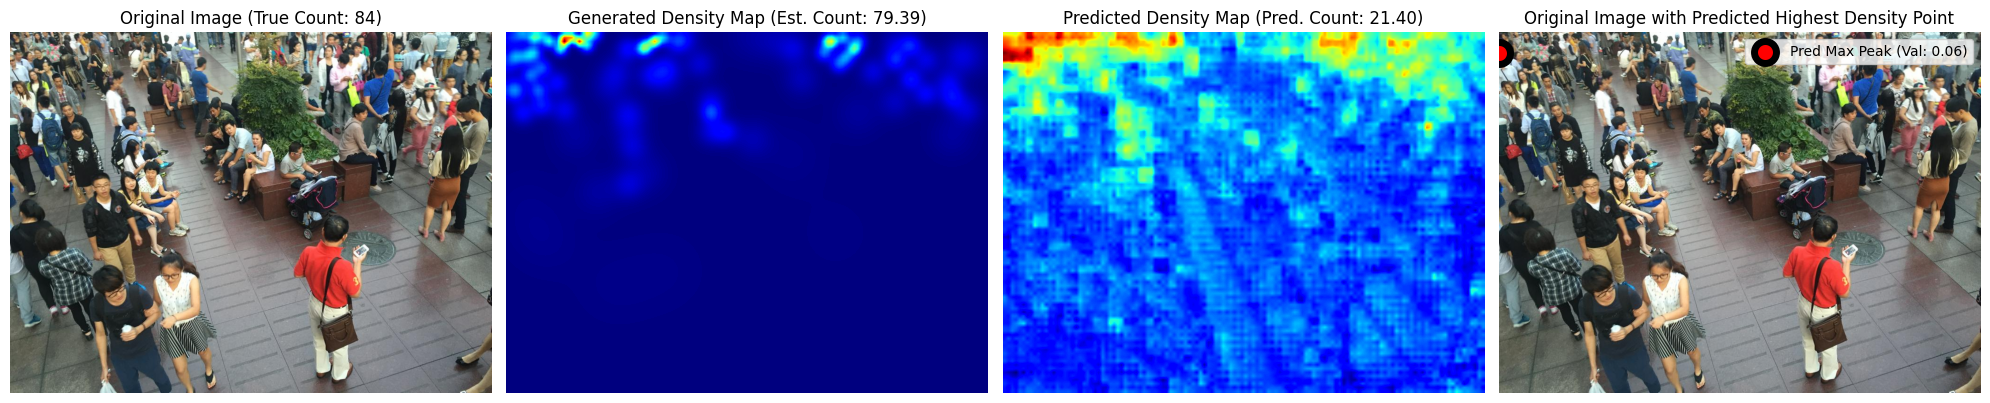

In [19]:
from scipy.ndimage import maximum_filter


data = loadmat('/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/ground_truth/GT_IMG_40.mat')
point = data["image_info"][0][0][0][0][0]


img = Image.open("/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/images/IMG_40.jpg").convert("RGB")
width, height = img.size

density_map = generate_density_map(img, points=point.astype(int))
density_map_tensor = torch.from_numpy(density_map).float().unsqueeze(0).unsqueeze(0)
upsampled_density_map = torch.nn.functional.interpolate(
    density_map_tensor,
    size=(img.size[1], img.size[0]),
    mode='bilinear',
    align_corners=False).squeeze().cpu().numpy()


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
with torch.no_grad():
    img_ = transform(img)
    img_ = img_.to(device)
    predicted_density_map = model(img_.unsqueeze(0))
    upsampled_predicted_density_map = torch.nn.functional.interpolate(
        predicted_density_map,
        size=(height, width),
        mode='bilinear',
        align_corners=False).squeeze().cpu().numpy()


true_count = len(point)
estimated_count = np.sum(density_map)
predicted_count = predicted_density_map.sum().item()


max_pred_density_value = np.max(upsampled_predicted_density_map)
max_pred_density_coords_flat = np.argmax(upsampled_predicted_density_map)
max_pred_density_peak_row, max_pred_density_peak_col = np.unravel_index(
    max_pred_density_coords_flat, upsampled_predicted_density_map.shape
)


plt.figure(figsize=(20, 6))

plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title(f'Original Image (True Count: {true_count})')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(upsampled_density_map, cmap='jet')
plt.title(f'Generated Density Map (Est. Count: {estimated_count:.2f})')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(upsampled_predicted_density_map, cmap='jet')
plt.title(f'Predicted Density Map (Pred. Count: {predicted_count:.2f})')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(img)
plt.scatter(max_pred_density_peak_col, max_pred_density_peak_row, 
            color='red', s=1000, marker='.', edgecolors='black', linewidth=5, 
            label=f'Pred Max Peak (Val: {max_pred_density_value:.2f})')
plt.title(f'Original Image with Predicted Highest Density Point')
plt.axis('off')
plt.legend()

plt.tight_layout()
plt.show()